# Flooded area segmentation using attention unet



## Imports and dataset

In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import glob

In [ ]:
images = sorted(glob.glob('/content/drive/MyDrive/imss/Image/*.jpg'))
masks = sorted(glob.glob('/content/drive/MyDrive/imss/Mask/*.png'))
len(images), len(masks)

(290, 290)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Custom data generator

In [ ]:
import numpy as np
import cv2
import os
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class CustomDataGenerator(keras.utils.Sequence):
    def __init__(self, images, masks, batch_size=8, img_size=(512, 512), shuffle=True):
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.images = images #os.listdir(image_folder)
        self.masks = masks #os.listdir(mask_folder)

        # on each epoch end, shuffle the dataset
        self.on_epoch_end()

        # datagen function to augment the input image and mask pair
        self.datagen = ImageDataGenerator(
            rotation_range=5,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.05,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode = 'constant',
            cval=0.0,
        )

    # randomly crop the images to 512x512 size
    def random_crop(self, image, mask, crop_size=512):

        # image width and height calculation
        img_height, img_width = image.shape[0], image.shape[1]
        mask_height, mask_width = mask.shape[0], mask.shape[1]

        # random x and y coordinate for cropping the image
        x = np.random.randint(0, img_width - crop_size)
        y = np.random.randint(0, img_height - crop_size)

        # random crop
        image_crop = image[y:y + crop_size, x:x + crop_size, :]
        mask_crop = mask[y:y + crop_size, x:x + crop_size]

        return image_crop, mask_crop

    # data augmentation using keras ImageDataGenerator function
    def data_augmentation(self, image, mask):
        trans_param = self.datagen.get_random_transform(image.shape)
        image = self.datagen.apply_transform(image, trans_param)
        mask = self.datagen.apply_transform(mask, trans_param)
        return image, mask

    # length of the processing batch
    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    # data normalization
    def data_normalization(self, image, mask):

        # reshape mask from 512x512 to 512x512x1
        mask = mask.reshape((*self.img_size, 1))

        # Binary mask
        mask = np.where(mask<127, 0, 1)

        # data normalization (If you want to normalize another way, change the below line)
        image = image / 255.0

        # return image and mask
        return image, mask

    # data preprocessing, resize, crop image etc
    def data_preprocessing(self, image, mask):
        image, mask = cv2.resize(image, (576, 576)), cv2.resize(mask, (576, 576))
        image, mask = self.random_crop(image, mask)
        return image, mask

    # on each epoch, shuffle the dataset (image and mask index)
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.images))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    # get item is the core function
    # this function will run in each batch/epoch to load the dataset into RAM and pass to DL model
    def __getitem__(self, index):

        # start and end index
        # the last index can be shorter than the number of batches
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.images))
        indexes = self.indexes[start_idx:end_idx]

        # initialize the images and mask batches
        batch_images = []
        batch_masks = []

        # iterate over each indexes in batch
        for i in indexes:
            img_path = self.images[i]
            mask_path = self.masks[i]

            # read image using open cv
            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Skip if image or mask is not loaded properly
            if img is None or mask is None:
                continue

            # image preprocessing; resize, random crop
            img, mask = self.data_preprocessing(img, mask)

            # data normalization
            img, mask = self.data_normalization(img, mask)

            # data augmentation
            img, mask = self.data_augmentation(img, mask)

            # to fix the issue during training process
            mask = mask.astype(np.float32)

            # append each image, mask pair to the batches
            batch_images.append(img)
            batch_masks.append(mask)

        # return batch image and batch mamks as a numpy array (n, tile_x, tile_y, channels)
        return np.array(batch_images), np.array(batch_masks)

## Testing and visualization of image/mask pair

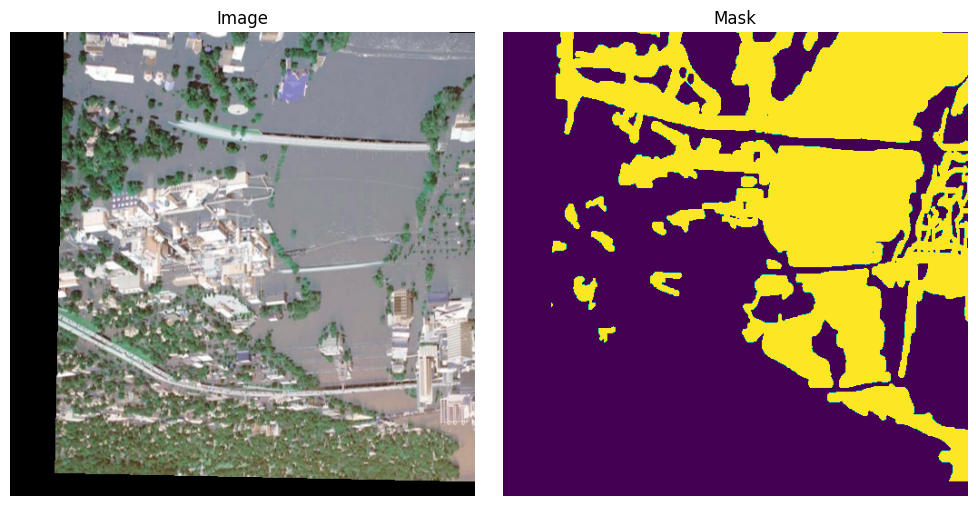

In [ ]:
import matplotlib.pyplot as plt

data = CustomDataGenerator(images, masks)
batch_images, batch_masks = data.__getitem__(0)

img = np.random.randint(0,8)
# Visualize the first image and its mask from the batch
image = batch_images[img]
mask = batch_masks[img]

# Plotting the image and its mask
plt.figure(figsize=(10, 5))

# Display Image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Image')
plt.axis('off')

# Display Mask
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title('Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

## Train and test dataset split

In [ ]:
from sklearn.model_selection import train_test_split
train_img, test_img, train_mask, test_mask = train_test_split(images, masks, test_size=0.2, random_state=42)

In [ ]:
len(train_img), len(test_img)

(232, 58)

In [ ]:
train_dataset = CustomDataGenerator(train_img, train_mask)
test_dataset = CustomDataGenerator(test_img, test_mask)

In [ ]:
len(train_dataset), len(test_dataset)

(29, 8)

## Custom metrics

1. Precision
2. Recall
3. F1-Score
4. Dice loss

## Custom loss function

Instead of default loss function (`binary_crossentropy`), you can use the `dice_loss` function implemented below as well.

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

# recall
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#f1 score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

## Attention unet

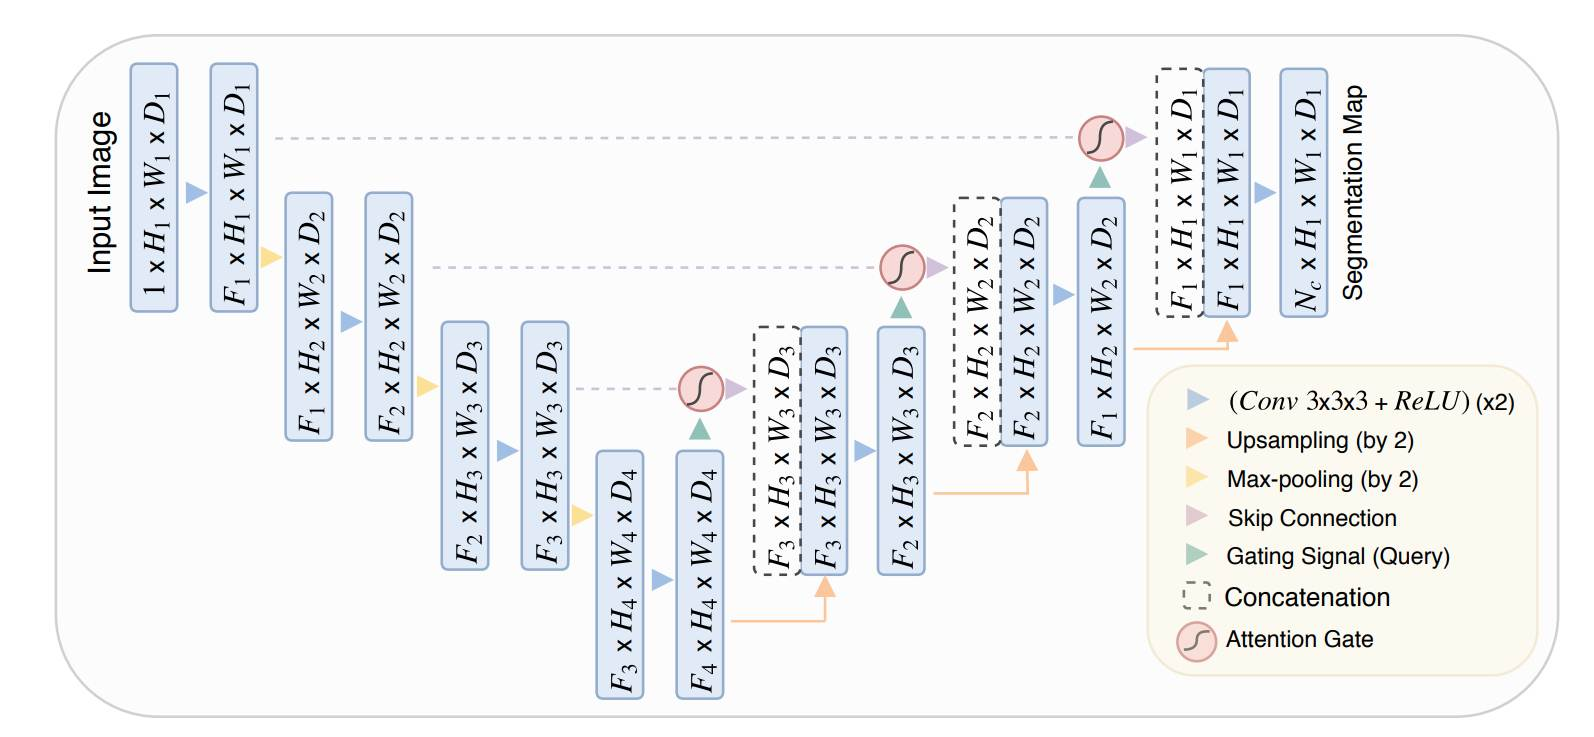

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Conv2DTranspose,
    concatenate, Activation, BatchNormalization, Lambda, add, multiply
)
from tensorflow.keras.optimizers import Adam

# Define global metric instances
precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()

def f1_m(y_true, y_pred):
    # Reset states before updating
    precision_metric.reset_state()
    recall_metric.reset_state()

    # Update metrics
    precision_metric.update_state(y_true, y_pred)
    recall_metric.update_state(y_true, y_pred)

    # Calculate precision and recall
    precision = precision_metric.result()
    recall = recall_metric.result()

    # Compute F1 score
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

def precision_m(y_true, y_pred):
    precision_metric.reset_state()
    precision_metric.update_state(y_true, y_pred)
    return precision_metric.result()

def recall_m(y_true, y_pred):
    recall_metric.reset_state()
    recall_metric.update_state(y_true, y_pred)
    return recall_metric.result()

def dsc(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2. * intersection + K.epsilon()) / (union + K.epsilon())


def expend_as(tensor, rep, name):
    my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                       arguments={'repnum': rep}, name='psi_up' + name)(tensor)
    return my_repeat

def AttnGatingBlock(x, g, inter_shape, name):
    shape_x = tf.keras.backend.int_shape(x)
    shape_g = tf.keras.backend.int_shape(g)

    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same', name='xl' + name)(x)
    shape_theta_x = tf.keras.backend.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(g)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),
                                  strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                  padding='same', name='g_up' + name)(phi_g)

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same', name='psi' + name)(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = tf.keras.backend.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)

    y = multiply([upsample_psi, x], name='q_attn' + name)
    result = Conv2D(shape_x[3], (1, 1), padding='same', name='q_attn_conv' + name)(y)
    result_bn = BatchNormalization(name='q_attn_bn' + name)(result)
    return result_bn

def UnetConv2D(input, outdim, is_batchnorm, name):
    x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer='glorot_normal', padding="same", name=name + '_1')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_1_bn')(x)
    x = Activation('relu', name=name + '_1_act')(x)

    x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer='glorot_normal', padding="same", name=name + '_2')(x)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_2_bn')(x)
    x = Activation('relu', name=name + '_2_act')(x)
    return x

def UnetGatingSignal(input, is_batchnorm, name):
    shape = tf.keras.backend.int_shape(input)
    x = Conv2D(shape[3] * 1, (1, 1), strides=(1, 1), padding="same", kernel_initializer='glorot_normal', name=name + '_conv')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_bn')(x)
    x = Activation('relu', name=name + '_act')(x)
    return x

def attn_unet(lr, loss_func=None, pretrained_weights=None, input_size=(256, 256, 3)):
    inputs = Input(shape=input_size)

    # Contraction path
    conv1 = UnetConv2D(inputs, 64, is_batchnorm=True, name='conv1')
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = UnetConv2D(pool1, 64, is_batchnorm=True, name='conv2')
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = UnetConv2D(pool2, 128, is_batchnorm=True, name='conv3')
    conv3 = Dropout(0.1, name='drop_conv3')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = UnetConv2D(pool3, 128, is_batchnorm=True, name='conv4')
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = UnetConv2D(pool4, 256, is_batchnorm=True, name='conv5')
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    conv6 = UnetConv2D(pool5, 256, is_batchnorm=True, name='conv6')
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)

    # Center layer
    center = UnetConv2D(pool6, 512, is_batchnorm=True, name='center')

    # Expansion path
    g1 = UnetGatingSignal(center, is_batchnorm=True, name='g1')
    attn1 = AttnGatingBlock(conv6, g1, 512, '_1')
    convt1 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer='glorot_normal', name='convt1')(center)
    up1 = concatenate([convt1, attn1], name='up1')

    g2 = UnetGatingSignal(up1, is_batchnorm=True, name='g2')
    attn2 = AttnGatingBlock(conv5, g2, 256, '_2')
    convt2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer='glorot_normal', name='convt2')(up1)
    up2 = concatenate([convt2, attn2], name='up2')

    g3 = UnetGatingSignal(up2, is_batchnorm=True, name='g3')
    attn3 = AttnGatingBlock(conv4, g3, 128, '_3')
    convt3 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer='glorot_normal', name='convt3')(up2)
    up3 = concatenate([convt3, attn3], name='up3')

    g4 = UnetGatingSignal(up3, is_batchnorm=True, name='g4')
    attn4 = AttnGatingBlock(conv3, g4, 128, '_4')
    convt4 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer='glorot_normal', name='convt4')(up3)
    up4 = concatenate([convt4, attn4], name='up4')

    g5 = UnetGatingSignal(up4, is_batchnorm=True, name='g5')
    attn5 = AttnGatingBlock(conv2, g5, 64, '_5')
    attn5 = Dropout(0.2, name='drop_attn5')(attn5)
    convt5 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer='glorot_normal', name='convt5')(up4)
    up5 = concatenate([convt5, attn5], name='up5')

    convt6 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer='glorot_normal', name='convt6')(up5)
    up6 = concatenate([convt6, conv1], name='up6')
    conv10 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer='glorot_normal', name='final')(up6)

    model = Model(inputs, conv10)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', f1_m, precision_m, recall_m, dsc])

    if pretrained_weights:
        model.load_weights(pretrained_weights)

    return model

# Example usage
model = attn_unet(0.001, loss_func='binary_crossentropy', input_size=(512, 512, 3))
# model.summary()


## Training model

In [ ]:



checkpointer = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/dl/flood/flood_best.keras",
    monitor="val_f1_m",
    verbose=1,
    save_best_only=True,
    mode="max"
)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_m', patience=5, verbose=1, mode='max')

callbacks = [earlyStopping, checkpointer]

# Model training
history = model.fit(
    train_dataset,
    epochs=50,
    verbose=1,
    validation_data=test_dataset,
    callbacks=callbacks
)

# Save the final model in the `.keras` format
model.save("/content/drive/MyDrive/dl/flood/flood_save.keras")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7844 - dsc: 0.6262 - f1_m: 0.7097 - loss: 0.4633 - precision_m: 0.7063 - recall_m: 0.7321
Epoch 1: val_f1_m improved from -inf to 0.59024, saving model to /content/drive/MyDrive/dl/flood/flood_best.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 312s 7s/step - accuracy: 0.7853 - dsc: 0.6273 - f1_m: 0.7109 - loss: 0.4617 - precision_m: 0.7078 - recall_m: 0.7328 - val_accuracy: 0.4847 - val_dsc: 0.4675 - val_f1_m: 0.5902 - val_loss: 0.6935 - val_precision_m: 0.4216 - val_recall_m: 0.9994
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.8410 - dsc: 0.6891 - f1_m: 0.7760 - loss: 0.3731 - precision_m: 0.8207 - recall_m: 0.7480
Epoch 2: val_f1_m did not improve from 0.59024
29/29 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.8410 - dsc: 0.6891 - f1_m: 0.7760 - loss: 0.3729 - precision_m: 0.8205 - recall_m: 0.7480 - val_accuracy: 0.3669 - val_dsc: 0.5196 - val_f1_m: 0.5629 - val_loss: 0.7669 - val_precision_m: 0.4049 - val_recall_m: 1.000

## Model performance

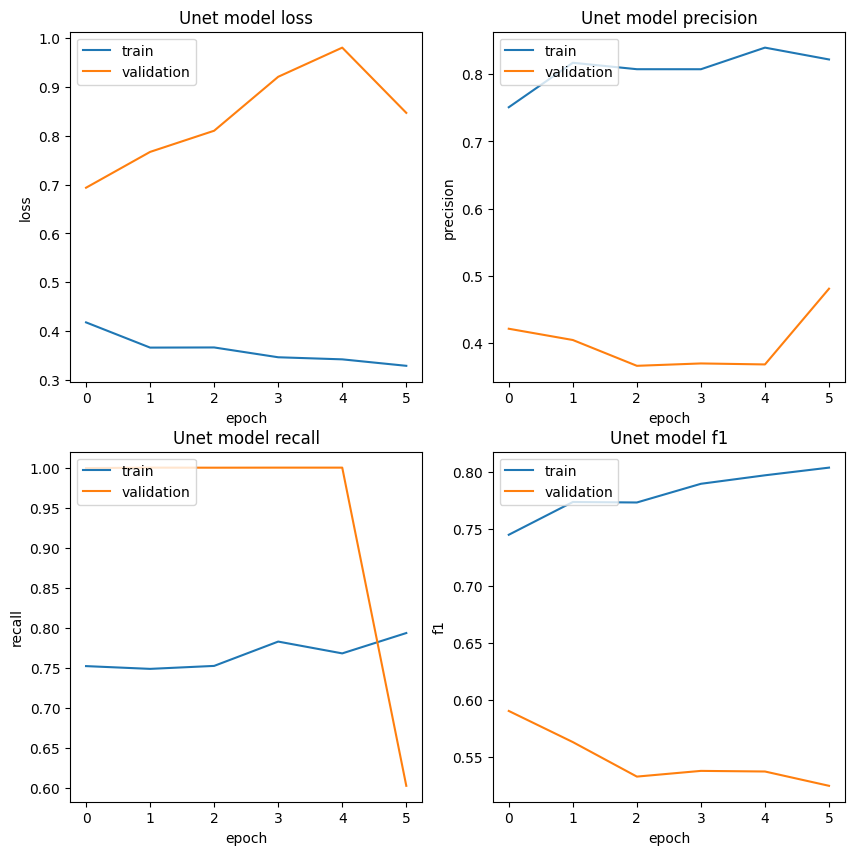

In [ ]:
fig,((ax11, ax12),(ax13,ax14)) = plt.subplots(2,2,figsize=(10,10))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.title.set_text('Unet model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('Unet model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('Unet model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('Unet model f1')
ax14.set_ylabel('f1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')

## Load best model

In [ ]:
from keras.models import load_model

# Define the custom loss function before loading the model
custom_objects = {"f1_m": f1_m, 'precision_m': precision_m, 'recall_m': recall_m, 'dsc': dsc}

model = load_model('/content/drive/MyDrive/dl/flood/flood_best.keras', custom_objects=custom_objects)

# pred

In [ ]:
# accuracy, f1_score, precision, recall, dsc = model.evaluate(test_dataset, verbose=0)
loss, accuracy, f1_score, precision, recall, dsc = model.evaluate(test_dataset, verbose=0)
print(loss, accuracy, f1_score, precision, recall, dsc)


0.6939128637313843 0.47875910997390747 0.5555791854858398 0.39275699853897095 0.9988415837287903 0.4432198405265808


## Prediction on custom images

In [ ]:
import glob
imgs = glob.glob('/content/drive/MyDrive/imgs/*.jpeg')

img_test = np.zeros((3, 512, 512, 3))
for index, i in enumerate(imgs):
  img = cv2.imread(i)
  img = cv2.resize(img, (512, 512))
  img = img / 255.0
  # print(img.shape)
  img_test[index] = img


In [ ]:
print(imgs)

['/content/drive/MyDrive/imgs/flood2.jpeg', '/content/drive/MyDrive/imgs/flood3.jpeg', '/content/drive/MyDrive/imgs/flood1.jpeg']


In [ ]:
pred = model.predict(img_test)
pred = np.where(pred > 0.5, 1, 0)
pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


(3, 512, 512, 1)

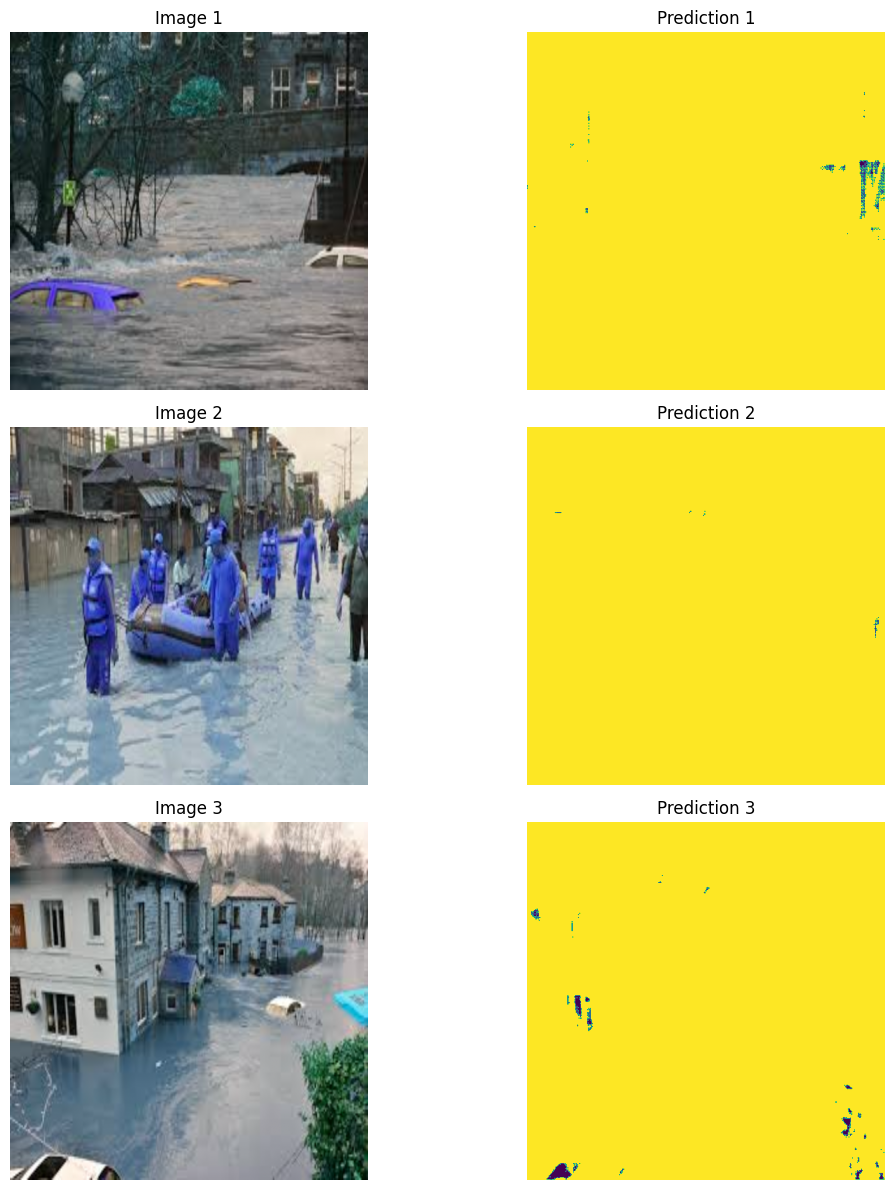

In [ ]:
fig,(axes)= plt.subplots(3, 2, figsize=(12,12))

for i in range(3):
    # Load and display the original image
    axes[i, 0].imshow(img_test[i])
    axes[i, 0].set_title(f'Image {i+1}')
    axes[i, 0].axis('off')

    # Load and display the corresponding prediction
    axes[i, 1].imshow(pred[i])
    axes[i, 1].set_title(f'Prediction {i+1}')
    axes[i, 1].axis('off')

plt.tight_layout()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


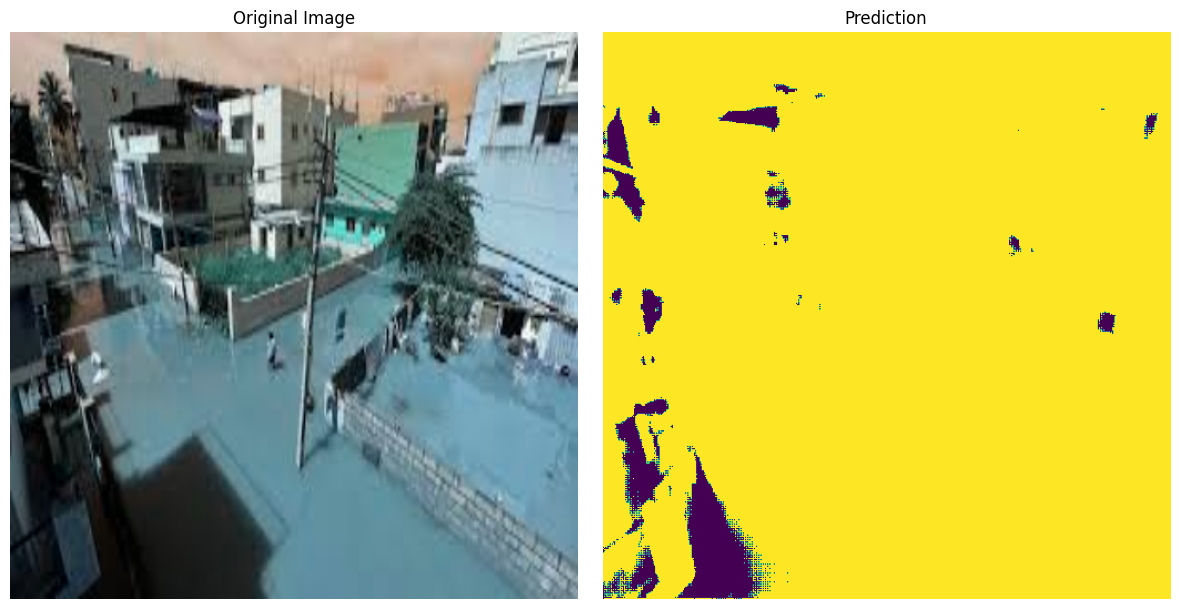

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Path to the single image
image_path = '/content/flood6.jpeg'

# Load and preprocess the image
img = cv2.imread(image_path)  # Read the image
img = cv2.resize(img, (512, 512))  # Resize to match model input
img = img / 255.0  # Normalize the image to [0, 1] range
img_test = np.expand_dims(img, axis=0)  # Add batch dimension

# Predict
pred = model.predict(img_test)
pred = np.where(pred > 0.5, 1, 0)

# Plot the original image and prediction
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image
axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display the prediction
axes[1].imshow(pred[0])  # Remove batch dimension for display
axes[1].set_title('Prediction')
axes[1].axis('off')

plt.tight_layout()
plt.show()
